In [1]:
import seaborn as sns

In [2]:
from google.colab import files

In [3]:
from scipy import stats

In [4]:
import pickle
import os

from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/usr/local/lib/python3.10/dist-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [5]:
from google.colab import drive

In [6]:
df = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/DSMarket/df_final_PK")


In [7]:
pd.__version__

'1.5.2'

In [8]:
xgb.__version__

'1.3.3'

In [9]:
import os

if pd.__version__ != "1.5.2":
    os.system("pip install pandas==1.5.2")

if xgb.__version__ != "1.3.3":
    os.system("pip install xgboost==1.3.3")

In [10]:
! pip install pandas==1.5.2


#DATA UNDERSTANDING

In [11]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           30490 non-null  object        
 1   item         30490 non-null  object        
 2   category     30490 non-null  object        
 3   department   30490 non-null  object        
 4   store        30490 non-null  object        
 5   store_code   30490 non-null  object        
 6   region       30490 non-null  object        
 7   sales_total  30490 non-null  int64         
 8   yearweek     30490 non-null  object        
 9   sell_price   30490 non-null  float64       
 10  date         30490 non-null  datetime64[ns]
 11  Revenue      30490 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(8)
memory usage: 2.8+ MB


In [12]:
df.head()


,id,item,category,department,store,store_code,region,sales_total,yearweek,sell_price,date,Revenue
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,600,2013-28,12.7414,2013-07-15,7644.8400
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,493,2011-25,5.2801,2011-06-20,2603.0893
2,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,288,2014-05,3.9501,2014-02-03,1137.6288
3,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,3288,2011-10,5.7722,2011-03-07,18978.9936
4,ACCESORIES_1_005_NYC_1,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,1849,2011-21,3.9634,2011-05-23,7328.3266


In [13]:
#eliminamos 'id' ya que solo tiene una fecha por registro

In [14]:
df.drop('id', axis = 1, inplace = True)


In [15]:
df["item"].nunique()


3049

In [16]:
len(sorted(df['date'].unique()))

259

In [17]:
df.shape

(30490, 11)

In [18]:
df['date'].value_counts(ascending=False)

2011-01-31    10932
2011-02-07     1043
2011-02-14      544
2011-03-07      301
2011-02-21      280
              ...  
2015-11-16        1
2015-08-10        1
2016-01-11        1
2015-11-30        1
2015-06-29        1
Name: date, Length: 259, dtype: int64

In [19]:
# Ventas Enero-2011 -> junio-2015 -- 54 Train
# Predicción julio-2015 -- Predict

In [20]:
df.describe(include =np.number).T


,count,mean,std,min,25%,50%,75%,max
sales_total,30490.0,2154.654280,5217.226438,10.00,355.0000,848.00000,2031.750,250502.0000
sell_price,30490.0,5.494923,4.521271,0.12,2.5004,4.00800,7.150,39.8601
Revenue,30490.0,7465.859675,13802.033887,18.62,1713.3864,3738.60625,7957.695,530638.9200


In [21]:
df.describe(exclude= np.number).T


<ipython-input-21-1c34252a686c>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(exclude= np.number).T


,count,unique,top,freq,first,last
item,30490,3049,ACCESORIES_1_001,10,NaT,NaT
category,30490,3,SUPERMARKET,14370,NaT,NaT
department,30490,7,SUPERMARKET_3,8230,NaT,NaT
store,30490,10,Greenwich_Village,3049,NaT,NaT
store_code,30490,10,NYC_1,3049,NaT,NaT
region,30490,3,New York,12196,NaT,NaT
yearweek,30490,259,2011-05,10932,NaT,NaT
date,30490,259,2011-01-31 00:00:00,10932,2011-01-31,2016-02-15


In [22]:
df[df.duplicated()]


,item,category,department,store,store_code,region,sales_total,yearweek,sell_price,date,Revenue


In [23]:
df.isnull().sum()


item           0
category       0
department     0
store          0
store_code     0
region         0
sales_total    0
yearweek       0
sell_price     0
date           0
Revenue        0
dtype: int64

In [24]:
df['yearweek'] = df['yearweek'].apply(lambda x: x.replace('-', ''))


In [25]:
df['yearweek'].value_counts()

201105    10932
201106     1043
201107      544
201110      301
201108      280
          ...  
201546        1
201532        1
201602        1
201548        1
201526        1
Name: yearweek, Length: 259, dtype: int64

In [26]:
df['yearweek'] = df['yearweek'].astype(int)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   item         30490 non-null  object        
 1   category     30490 non-null  object        
 2   department   30490 non-null  object        
 3   store        30490 non-null  object        
 4   store_code   30490 non-null  object        
 5   region       30490 non-null  object        
 6   sales_total  30490 non-null  int64         
 7   yearweek     30490 non-null  int64         
 8   sell_price   30490 non-null  float64       
 9   date         30490 non-null  datetime64[ns]
 10  Revenue      30490 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 2.6+ MB


In [28]:
sample_ts = "ACCESORIES_1_001"


In [29]:
ts = df[df["item"] == sample_ts][["date", "sales_total", "sell_price"]]


In [30]:
ts

,date,sales_total,sell_price
0,2013-07-15,600,12.7414
3049,2013-07-29,542,10.9858
6098,2013-07-22,758,10.9858
9147,2013-07-15,635,12.7414
12196,2013-07-15,260,12.7414
15245,2013-07-29,402,12.7414
18294,2013-07-29,385,11.4646
21343,2013-07-15,178,12.7414
24392,2013-07-29,115,11.4646
27441,2013-08-05,218,10.9858


In [31]:
df.set_index("date").resample("3M")["sales_total"].sum()


date
2011-01-31    37590863
2011-04-30     6387820
2011-07-31     1317534
2011-10-31     2433375
2012-01-31     2464090
2012-04-30     2651664
2012-07-31     2826888
2012-10-31     1711638
2013-01-31     1272309
2013-04-30     2471247
2013-07-31     1223893
2013-10-31      723477
2014-01-31      461189
2014-04-30     1038333
2014-07-31      427226
2014-10-31      263212
2015-01-31      235087
2015-04-30       76604
2015-07-31       90922
2015-10-31       24449
2016-01-31        2745
2016-04-30         844
Freq: 3M, Name: sales_total, dtype: int64

In [32]:
MIN_DATE = df["date"].min()
MAX_DATE = df["date"].max()

In [33]:
print(f"Min date is {MIN_DATE}\nMax date is {MAX_DATE}")

Min date is 2011-01-31 00:00:00
Max date is 2016-02-15 00:00:00


In [34]:
df['item'].value_counts()

ACCESORIES_1_001       10
SUPERMARKET_2_210      10
SUPERMARKET_2_201      10
SUPERMARKET_2_202      10
SUPERMARKET_2_203      10
                       ..
HOME_&_GARDEN_1_464    10
HOME_&_GARDEN_1_465    10
HOME_&_GARDEN_1_466    10
HOME_&_GARDEN_1_467    10
SUPERMARKET_3_827      10
Name: item, Length: 3049, dtype: int64

In [35]:
 df[df["item"] == sample_ts].value_counts()

item              category    department    store              store_code  region        sales_total  yearweek  sell_price  date        Revenue  
ACCESORIES_1_001  ACCESORIES  ACCESORIES_1  Back_Bay           BOS_3       Boston        385          201330    11.4646     2013-07-29  4413.8710    1
                                            Brooklyn           NYC_4       New York      635          201328    12.7414     2013-07-15  8090.7890    1
                                            Greenwich_Village  NYC_1       New York      600          201328    12.7414     2013-07-15  7644.8400    1
                                            Harlem             NYC_2       New York      542          201330    10.9858     2013-07-29  5954.3036    1
                                            Midtown_Village    PHI_1       Philadelphia  178          201328    12.7414     2013-07-15  2267.9692    1
                                            Queen_Village      PHI_3       Philadelphia  218       

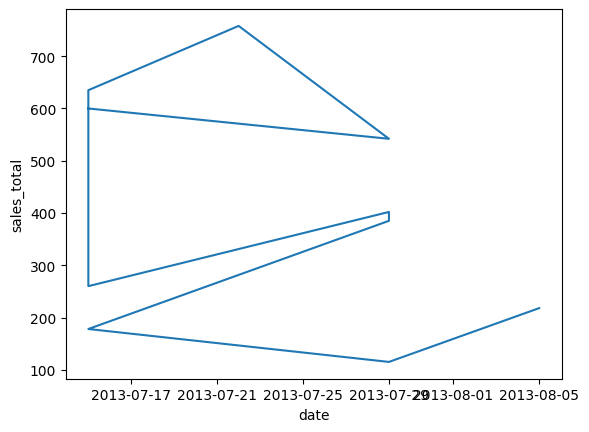

In [36]:
serie_temporal = df[df["item"] == sample_ts]
# Graficar la serie
plt.plot(serie_temporal["date"], serie_temporal["sales_total"])
plt.xlabel("date")
plt.ylabel("sales_total")
plt.show()


<a id='eda_global_sales'></a>
### --> 1. EDA: Global Sales
[Volver al índice](#index)<br>

In [37]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2, lags = 14)
    plot_pacf(x = y, ax = ax3, lags = 14)

    plt.suptitle(t = title, fontsize = 20)

In [38]:
y = df.set_index("date").resample("w")["sales_total"].sum()[:-1] # quitamos los registros de la ultima semana


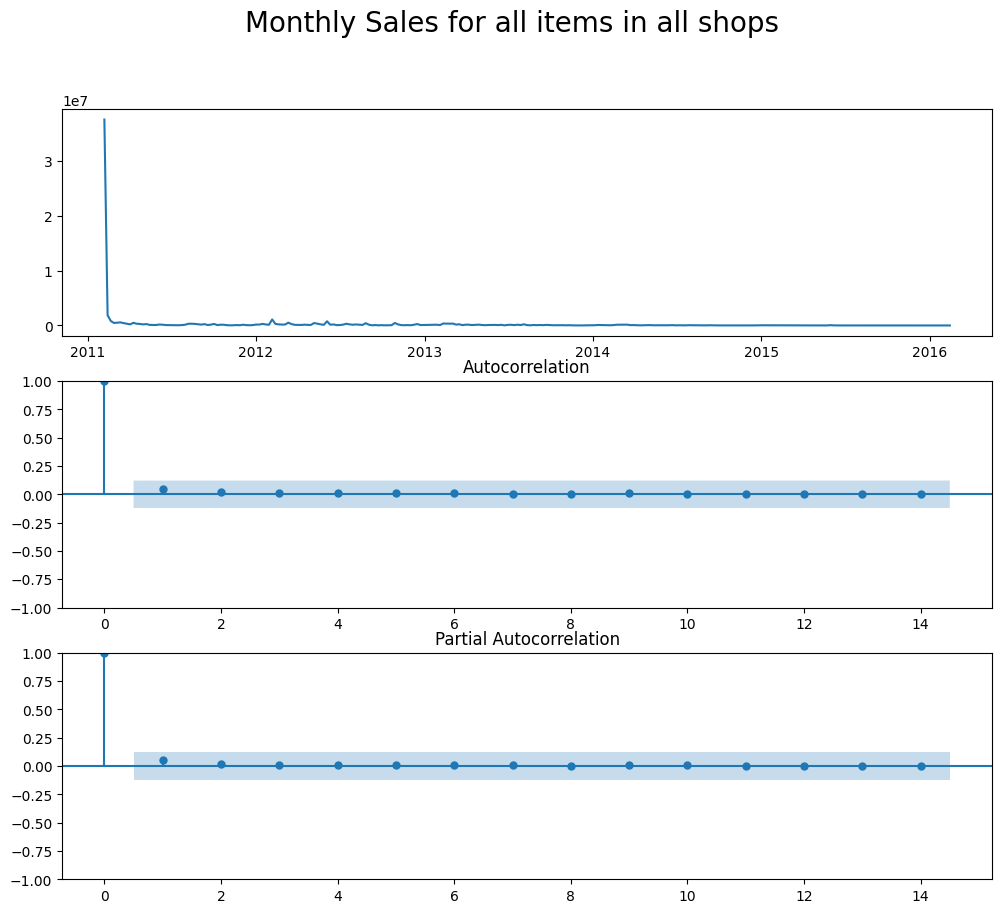

In [39]:
plot_ts_acf_pacf(y = y, title = "Monthly Sales for all items in all shops");


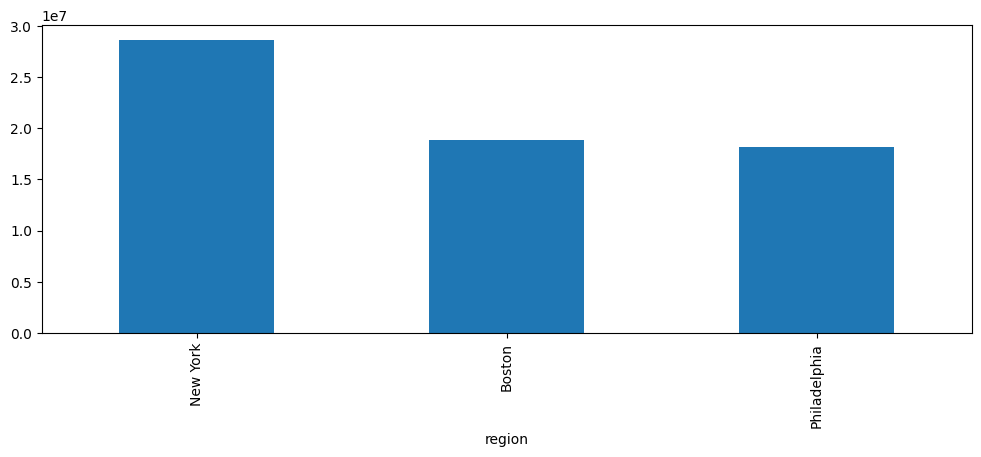

In [40]:
(
    df.
    groupby(["region"])
    ["sales_total"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

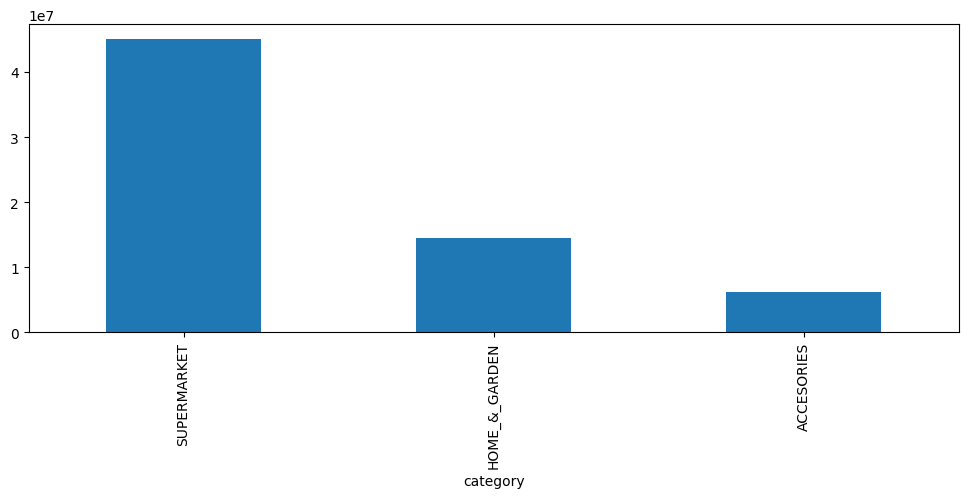

In [41]:
(
    df.
    groupby(["category"])
    ["sales_total"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

Nuevas variables

In [42]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month


In [43]:
df["week"] = df["date"].dt.week

<ipython-input-43-d7e41df042a9>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df["week"] = df["date"].dt.week


In [44]:
df['last_purchase_date'] = df['date'].max()
df['last_purchase_date'] = df['last_purchase_date'].astype(np.int64)

In [45]:
df.groupby(["region"])["sales_total"].sum()

region
Boston          18899006
New York        28675547
Philadelphia    18120856
Name: sales_total, dtype: int64

In [46]:
gb_df=df.groupby(["region"])


In [47]:
df.select_dtypes(include= ['object']).describe().T


,count,unique,top,freq
item,30490,3049,ACCESORIES_1_001,10
category,30490,3,SUPERMARKET,14370
department,30490,7,SUPERMARKET_3,8230
store,30490,10,Greenwich_Village,3049
store_code,30490,10,NYC_1,3049
region,30490,3,New York,12196


In [48]:
gb_df.get_group(('New York')).head()

,item,category,department,store,store_code,region,sales_total,yearweek,sell_price,date,Revenue,year,month,week,last_purchase_date
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,600,201328,12.7414,2013-07-15,7644.8400,2013,7,29,1455494400000000000
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,493,201125,5.2801,2011-06-20,2603.0893,2011,6,25,1455494400000000000
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,288,201405,3.9501,2014-02-03,1137.6288,2014,2,6,1455494400000000000
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,3288,201110,5.7722,2011-03-07,18978.9936,2011,3,10,1455494400000000000
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,1849,201121,3.9634,2011-05-23,7328.3266,2011,5,21,1455494400000000000


In [49]:
len(gb_df)

3

In [50]:
regiontop_df= gb_df.get_group(('New York'))

In [51]:
regiontop_df_dia= regiontop_df[['date','sales_total']].groupby('date').sum()


In [52]:
regiontop_df_dia.index

DatetimeIndex(['2011-01-31', '2011-02-07', '2011-02-14', '2011-02-21',
               '2011-02-28', '2011-03-07', '2011-03-14', '2011-03-21',
               '2011-03-28', '2011-04-04',
               ...
               '2015-10-26', '2015-11-02', '2015-11-09', '2015-11-16',
               '2015-11-30', '2015-12-28', '2016-01-11', '2016-01-18',
               '2016-02-01', '2016-02-15'],
              dtype='datetime64[ns]', name='date', length=254, freq=None)

In [53]:
regiontop_df_dia.index = pd.to_datetime(regiontop_df_dia.index)


<Axes: xlabel='date'>

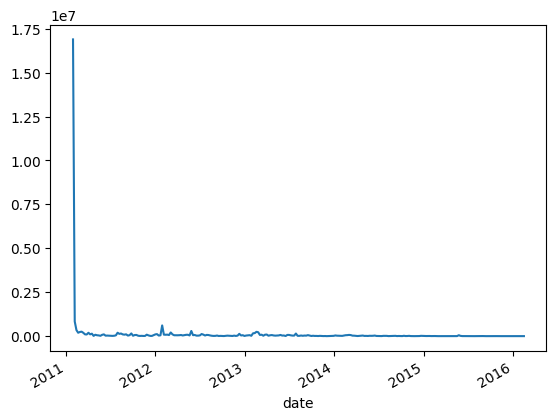

In [54]:
regiontop_df_dia['sales_total'].plot()


In [55]:
media_ventas_año = regiontop_df_dia['sales_total'].resample('Y').mean()


<Axes: xlabel='date'>

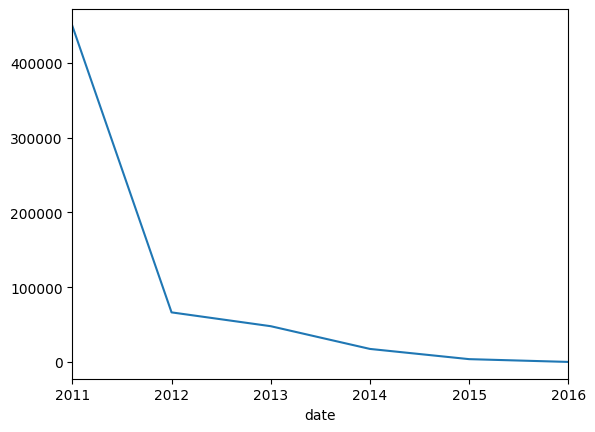

In [56]:
media_ventas_año.plot()


In [57]:
df.head(3)

,item,category,department,store,store_code,region,sales_total,yearweek,sell_price,date,Revenue,year,month,week,last_purchase_date
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,600,201328,12.7414,2013-07-15,7644.8400,2013,7,29,1455494400000000000
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,493,201125,5.2801,2011-06-20,2603.0893,2011,6,25,1455494400000000000
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,288,201405,3.9501,2014-02-03,1137.6288,2014,2,6,1455494400000000000


In [58]:
# nuevas variables de lag y medias móviles

In [59]:
df["month_store_region_sell_price_lag1"] = df.groupby(['month', 'store', 'region'])["sell_price"].transform(
    lambda series: series.shift(1).backfill().ffill())

In [60]:
df["month_store_region_sell_price_ma1"] = df.groupby(['month', 'store', 'region'])["sell_price"].transform(
    lambda series: series.shift(1).rolling(1).mean().backfill().ffill())

In [61]:
df["store_region_sales_total_lag1"] = df.groupby([ 'store', 'region'])["sales_total"].transform(
    lambda series: series.shift(1).backfill().ffill())

In [62]:
df["store_region_sales_total_ma1"] = df.groupby([ 'store', 'region'])["sales_total"].transform(
    lambda series: series.shift(1).rolling(1).mean().backfill().ffill())

In [63]:
df["store_item_sell_price_lag1"] = df.groupby([ 'store', 'item'])["sell_price"].transform(
    lambda series: series.shift(1).backfill().ffill())

In [64]:
df["store_item_sell_price_ma1"] = df.groupby([ 'store', 'item'])["sell_price"].transform(
    lambda series: series.shift(1).rolling(1).mean().backfill().ffill())

In [65]:
df["category_item_sales_total_lag1"] = df.groupby([ 'category', 'item'])["sales_total"].transform(
    lambda series: series.shift(1).backfill().ffill())

In [66]:
df["category_item_sales_total_ma1"] = df.groupby([ 'category', 'item'])["sales_total"].transform(
    lambda series: series.shift(1).rolling(1).mean().backfill().ffill())

In [67]:
df["department_week_region_sales_total_lag1"] = df.groupby([ 'department','week', 'region'])["sales_total"].transform(
    lambda series: series.shift(1).backfill().ffill())

In [68]:
df["department_week_region_sales_total_ma2"] = df.groupby([ 'department','week', 'region'])["sales_total"].transform(
    lambda series: series.shift(1).rolling(1).mean().backfill().ffill())

In [69]:
#lag2 y ma2

In [70]:
df["month_store_region_sell_price_lag2"] = df.groupby(['month', 'store', 'region'])["sell_price"].transform(
    lambda series: series.shift(2).backfill().ffill())

In [71]:
df["month_store_region_sell_price_ma2"] = df.groupby(['month', 'store', 'region'])["sell_price"].transform(
    lambda series: series.shift(2).rolling(2).mean().backfill().ffill())

In [72]:
df["store_region_sales_total_lag2"] = df.groupby([ 'store', 'region'])["sales_total"].transform(
    lambda series: series.shift(2).backfill().ffill())

In [73]:
df["store_region_sales_total_ma2"] = df.groupby([ 'store', 'region'])["sales_total"].transform(
    lambda series: series.shift(2).rolling(2).mean().backfill().ffill())

In [74]:
df["category_item_sales_total_lag2"] = df.groupby([ 'category', 'item'])["sales_total"].transform(
    lambda series: series.shift(2).backfill().ffill())

In [75]:
df["department_week_region_sales_total_lag2"] = df.groupby([ 'department','week', 'region'])["sales_total"].transform(
    lambda series: series.shift(2).backfill().ffill())

In [76]:
df["category_item_sales_total_ma2"] = df.groupby([ 'category', 'item'])["sales_total"].transform(
    lambda series: series.shift(2).rolling(2).mean().backfill().ffill())

In [77]:
#lag3 y ma3

In [78]:
df["category_item_sales_total_lag3"] = df.groupby([ 'category', 'item'])["sales_total"].transform(
    lambda series: series.shift(3).backfill().ffill())

In [79]:
df["department_week_region_sales_total_lag3"] = df.groupby([ 'department','week', 'region'])["sales_total"].transform(
    lambda series: series.shift(3).backfill().ffill())

In [80]:
df["category_item_sales_total_ma3"] = df.groupby([ 'category', 'item'])["sales_total"].transform(
    lambda series: series.shift(3).rolling(3).mean().backfill().ffill())

In [81]:
df["department_week_region_sales_total_ma3"] = df.groupby([ 'department','week', 'region'])["sales_total"].transform(
    lambda series: series.shift(3).rolling(3).mean().backfill().ffill())

###  Time Series Features

In [82]:
"""
def build_ts_vars(df, gb_list, target_column, agg_func, agg_func_name):

    assert "date" in df.columns.tolist(), "Date must be in df columns"

    new_name = "_".join(gb_list + [target_column] + [agg_func_name])

    gb_df_ = (
        df
        .set_index("date")
        .groupby(gb_list)
        .resample("M")[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )

    gb_df_[f"{new_name}_lag1"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(1).backfill().ffill()
    )
    gb_df_[f"{new_name}_lag2"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(2).backfill().ffill())
    gb_df_[f"{new_name}_lag3"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(3).backfill().ffill())


    gb_df_[f"{new_name}_ma1"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(1).rolling(1).mean().backfill().ffill())
    gb_df_[f"{new_name}_ma2"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(2).rolling(2).mean().backfill().ffill())
    gb_df_[f"{new_name}_ma3"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(3).rolling(3).mean().backfill().ffill())


    print(f"Dropping columns that might cause target leakage {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)

    return gb_df_
    """

'\ndef build_ts_vars(df, gb_list, target_column, agg_func, agg_func_name):\n\n    assert "date" in df.columns.tolist(), "Date must be in df columns"\n\n    new_name = "_".join(gb_list + [target_column] + [agg_func_name])\n\n    gb_df_ = (\n        df\n        .set_index("date")\n        .groupby(gb_list)\n        .resample("M")[target_column]\n        .apply(agg_func)\n        .to_frame()\n        .reset_index()\n        .rename(\n            columns = {\n                target_column : new_name\n            }\n        )\n    )\n\n    gb_df_[f"{new_name}_lag1"] = gb_df_.groupby(gb_list)[new_name].transform(\n        lambda series: series.shift(1).backfill().ffill()\n    )\n    gb_df_[f"{new_name}_lag2"] = gb_df_.groupby(gb_list)[new_name].transform(\n        lambda series: series.shift(2).backfill().ffill())\n    gb_df_[f"{new_name}_lag3"] = gb_df_.groupby(gb_list)[new_name].transform(\n        lambda series: series.shift(3).backfill().ffill())\n\n\n    gb_df_[f"{new_name}_ma1"] = gb_d

In [83]:
"""GB_LIST = ['month', 'store', 'region']
TARGET_COLUMN = "sell_price"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"

vars_ts_ = build_ts_vars(
    df = df,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME

)

vars_ts_.head(10)
"""

'GB_LIST = [\'month\', \'store\', \'region\']\nTARGET_COLUMN = "sell_price"\nAGG_FUNC = np.sum\nAGG_FUNC_NAME = "sum"\n\nvars_ts_ = build_ts_vars(\n    df = df,\n    gb_list = GB_LIST,\n    target_column = TARGET_COLUMN,\n    agg_func = AGG_FUNC,\n    agg_func_name =  AGG_FUNC_NAME\n\n)\n\nvars_ts_.head(10)\n'

In [84]:
#vars_ts_.head(3)


<a id='join_ts_features'></a>
### Join TS Features


In [85]:
df.head()

,item,category,department,store,store_code,region,sales_total,yearweek,sell_price,date,...,month_store_region_sell_price_ma2,store_region_sales_total_lag2,store_region_sales_total_ma2,category_item_sales_total_lag2,department_week_region_sales_total_lag2,category_item_sales_total_ma2,category_item_sales_total_lag3,department_week_region_sales_total_lag3,category_item_sales_total_ma3,department_week_region_sales_total_ma3
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,600,201328,12.7414,2013-07-15,...,11.65080,600.0,546.5,600.0,600.0,571.0,600.0,600.0,633.333333,838.000000
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,493,201125,5.2801,2011-06-20,...,8.61175,600.0,546.5,493.0,493.0,410.5,493.0,493.0,424.333333,678.666667
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,288,201405,3.9501,2014-02-03,...,9.07060,600.0,546.5,288.0,288.0,216.5,288.0,288.0,190.000000,1377.000000
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,3288,201110,5.7722,2011-03-07,...,10.78630,493.0,546.5,3288.0,3288.0,5395.5,3288.0,3288.0,7077.666667,1452.000000
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,1849,201121,3.9634,2011-05-23,...,3.29175,288.0,390.5,1849.0,1849.0,1944.0,1849.0,1849.0,2183.666667,1090.000000


## Data Preparation


In [86]:
def OHE(dataframe, column_name):
    _dummy_dataset = pd.get_dummies(dataframe[column_name], prefix=column_name)
    dataframe = pd.concat([dataframe, _dummy_dataset], axis=1)
    return dataframe.drop(column_name, axis=1)

In [87]:
ohe_list=['category', 'department', 'store', 'store_code', 'region']

In [88]:
for column in ohe_list:
  df = OHE(df, column)


In [89]:
print(df.shape)

(30490, 64)


In [90]:
df.dropna(axis=1, inplace=True)


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Data columns (total 57 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   item                                30490 non-null  object        
 1   sales_total                         30490 non-null  int64         
 2   yearweek                            30490 non-null  int64         
 3   sell_price                          30490 non-null  float64       
 4   date                                30490 non-null  datetime64[ns]
 5   Revenue                             30490 non-null  float64       
 6   year                                30490 non-null  int64         
 7   month                               30490 non-null  int64         
 8   week                                30490 non-null  int64         
 9   last_purchase_date                  30490 non-null  int64         
 10  month_store_region_sel

<a id='train_test_split'></a>
### Train Test Split
[Volver al índice](#index)<br>

In [92]:
df.columns.tolist()

['item',
 'sales_total',
 'yearweek',
 'sell_price',
 'date',
 'Revenue',
 'year',
 'month',
 'week',
 'last_purchase_date',
 'month_store_region_sell_price_lag1',
 'month_store_region_sell_price_ma1',
 'store_region_sales_total_lag1',
 'store_region_sales_total_ma1',
 'category_item_sales_total_lag1',
 'category_item_sales_total_ma1',
 'month_store_region_sell_price_lag2',
 'month_store_region_sell_price_ma2',
 'store_region_sales_total_lag2',
 'store_region_sales_total_ma2',
 'category_item_sales_total_lag2',
 'category_item_sales_total_ma2',
 'category_item_sales_total_lag3',
 'category_item_sales_total_ma3',
 'category_ACCESORIES',
 'category_HOME_&_GARDEN',
 'category_SUPERMARKET',
 'department_ACCESORIES_1',
 'department_ACCESORIES_2',
 'department_HOME_&_GARDEN_1',
 'department_HOME_&_GARDEN_2',
 'department_SUPERMARKET_1',
 'department_SUPERMARKET_2',
 'department_SUPERMARKET_3',
 'store_Back_Bay',
 'store_Brooklyn',
 'store_Greenwich_Village',
 'store_Harlem',
 'store_Midtown_

In [93]:
COLUMNS_TO_DROP = ['Revenue',
]

df.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [94]:
df.set_index("item", inplace = True)

In [95]:
df.sample(5)

,sales_total,yearweek,sell_price,date,year,month,week,last_purchase_date,month_store_region_sell_price_lag1,month_store_region_sell_price_ma1,...,store_code_NYC_1,store_code_NYC_2,store_code_NYC_3,store_code_NYC_4,store_code_PHI_1,store_code_PHI_2,store_code_PHI_3,region_Boston,region_New York,region_Philadelphia
item,,,,,,,,,,,,,,,,,,,,,
HOME_&_GARDEN_2_120,53,201439,9.925,2014-09-29,2014,9,40,1455494400000000000,4.3500,4.3500,...,0,0,0,1,0,0,0,0,1,0
SUPERMARKET_3_327,15578,201130,3.576,2011-07-25,2011,7,30,1455494400000000000,3.0000,3.0000,...,0,0,0,0,0,1,0,0,0,1
ACCESORIES_1_328,813,201105,7.315,2011-01-31,2011,1,5,1455494400000000000,2.6334,2.6334,...,0,0,1,0,0,0,0,0,1,0
SUPERMARKET_3_649,374,201212,6.576,2012-03-19,2012,3,12,1455494400000000000,2.3760,2.3760,...,0,0,0,0,0,0,0,1,0,0
SUPERMARKET_3_482,1657,201350,3.576,2013-12-16,2013,12,51,1455494400000000000,7.1760,7.1760,...,0,0,1,0,0,0,0,0,1,0


In [96]:
print(df.shape)

(30490, 55)


In [97]:
df.isnull().sum().sum()

0

In [98]:
train_index = sorted(list(df["date"].unique()))[:-200]

valida_index = [sorted(list(df["date"].unique()))[-200: -50]]

test_index = [sorted(list(df["date"].unique()))[-50:]]

In [99]:
print(f"Our train index is {train_index[:2]} - ... - {train_index[-2:]}\n")
print(f"Our validation index is {valida_index}\n")
print(f"Our test/prediction index is {test_index}\n")

Our train index is [numpy.datetime64('2011-01-31T00:00:00.000000000'), numpy.datetime64('2011-02-07T00:00:00.000000000')] - ... - [numpy.datetime64('2012-03-05T00:00:00.000000000'), numpy.datetime64('2012-03-12T00:00:00.000000000')]

Our validation index is [[numpy.datetime64('2012-03-19T00:00:00.000000000'), numpy.datetime64('2012-03-26T00:00:00.000000000'), numpy.datetime64('2012-04-02T00:00:00.000000000'), numpy.datetime64('2012-04-09T00:00:00.000000000'), numpy.datetime64('2012-04-16T00:00:00.000000000'), numpy.datetime64('2012-04-23T00:00:00.000000000'), numpy.datetime64('2012-04-30T00:00:00.000000000'), numpy.datetime64('2012-05-07T00:00:00.000000000'), numpy.datetime64('2012-05-14T00:00:00.000000000'), numpy.datetime64('2012-05-21T00:00:00.000000000'), numpy.datetime64('2012-05-28T00:00:00.000000000'), numpy.datetime64('2012-06-04T00:00:00.000000000'), numpy.datetime64('2012-06-11T00:00:00.000000000'), numpy.datetime64('2012-06-18T00:00:00.000000000'), numpy.datetime64('2012-06-

Rebalanceo

In [100]:


# Extrae todas las fechas únicas
fechas_unicas = sorted(list(df["date"].unique()))

# Define el tamaño de los conjuntos de entrenamiento, validación y prueba
num_train = 200
num_valida = 150
num_test = 50

# Crea los índices de entrenamiento y prueba
train_index = fechas_unicas[:num_train]
test_index = fechas_unicas[-num_test:]

# Crea el índice de validación repitiendo las muestras
valida_index = []
for fecha in fechas_unicas[-num_valida:]:
    valida_index.append(fecha)  # Añadir una vez para cada muestra
    valida_index.append(fecha)  # Repetir dos veces para triplicar el número de muestras
# Crea el índice de train repitiendo las muestras
train_index = []
for fecha in fechas_unicas[-num_train:]:
    train_index.append(fecha)  # Añadir una vez para cada muestra
    train_index.append(fecha)  # Repetir dos veces para triplicar el número de muestras

# Crea el índice de test repitiendo las muestras
test_index = []
for fecha in fechas_unicas[-num_test:]:
    test_index.append(fecha)  # Añadir una vez para cada muestra
    test_index.append(fecha)  # Repetir dos veces para triplicar el número de muestras


# Convierte los índices a listas (opcional)
train_index = list(train_index)
valida_index = list(valida_index)
test_index = list(test_index)

# Usa los índices para obtener los subconjuntos de datos
train_data = df[df["date"].isin(train_index)]
valida_data = df[df["date"].isin(valida_index)]
test_data = df[df["date"].isin(test_index)]




In [101]:
X_train = df[df["date"].isin(train_index)].drop(['sales_total', "date"], axis=1)
Y_train = df[df["date"].isin(train_index)]['sales_total']

X_valida = df[df["date"].isin(valida_index)].drop(['sales_total', "date"], axis=1)
Y_valida = df[df["date"].isin(valida_index)]['sales_total']

X_test = df[df["date"].isin(test_index)].drop(['sales_total', "date"], axis = 1)
Y_test = df[df["date"].isin(test_index)]['sales_total']

<a id='model_train'></a>
### Model Train

In [102]:

model = xgb.XGBRegressor(eval_metric = "rmse", seed = 175, early_stopping_rounds=15)

model.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_valida, Y_valida)], verbose = True,
)
early_stopping_rounds=15

[16:30:18] WARNING: ../src/learner.cc:541: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



/usr/local/lib/python3.10/dist-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index



[0]	validation_0-rmse:1920.52539	validation_1-rmse:1173.59241
[1]	validation_0-rmse:1514.12305	validation_1-rmse:936.46393
[2]	validation_0-rmse:1223.37915	validation_1-rmse:772.96112
[3]	validation_0-rmse:1030.22827	validation_1-rmse:668.28473
[4]	validation_0-rmse:895.87964	validation_1-rmse:598.69147
[5]	validation_0-rmse:794.86609	validation_1-rmse:538.05530
[6]	validation_0-rmse:732.02075	validation_1-rmse:496.82031
[7]	validation_0-rmse:671.78601	validation_1-rmse:468.58011
[8]	validation_0-rmse:629.13953	validation_1-rmse:441.32028
[9]	validation_0-rmse:604.19257	validation_1-rmse:429.17972
[10]	validation_0-rmse:582.67963	validation_1-rmse:418.15607
[11]	validation_0-rmse:567.04517	validation_1-rmse:409.65900
[12]	validation_0-rmse:553.35358	validation_1-rmse:405.43109
[13]	validation_0-rmse:537.76575	validation_1-rmse:398.86179
[14]	validation_0-rmse:520.91626	validation_1-rmse:391.13443
[15]	validation_0-rmse:507.51477	validation_1-rmse:383.41711
[16]	validation_0-rmse:496.9

### Model Evaluation

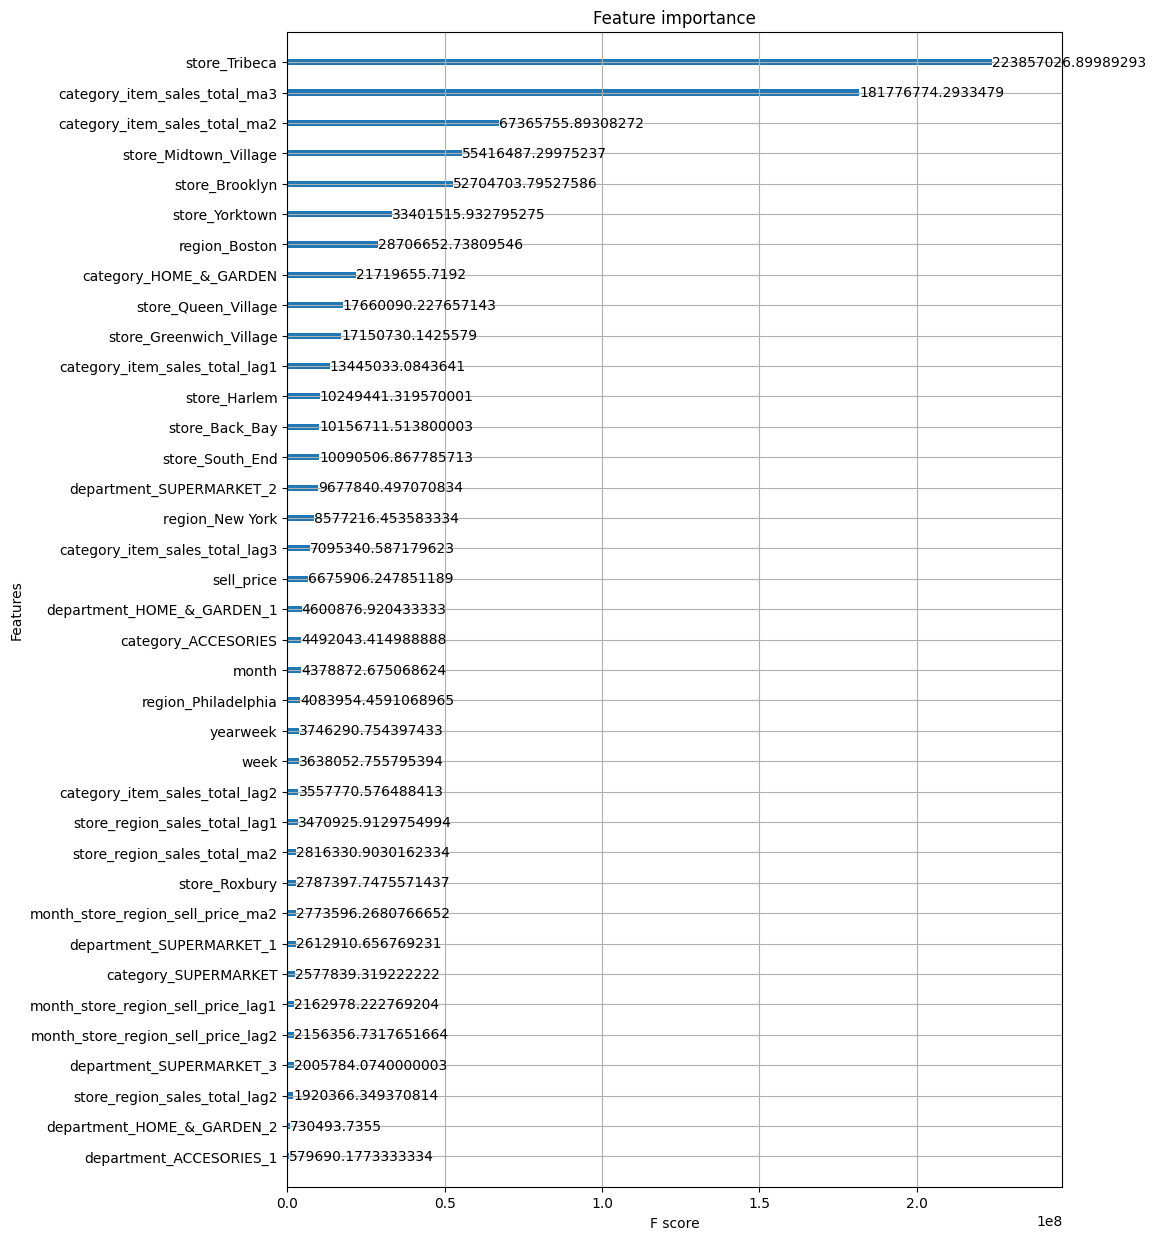

In [103]:
fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(model, importance_type = "gain", ax = ax);

### Prediction

In [104]:
if "sales_total" in X_test.columns:
    X_test.drop("sales_total", axis = 1, inplace = True)

Y_test_predict = model.predict(X_test)
X_test["sales_total"] = Y_test_predict

In [105]:
X_test.reset_index(inplace = True)

In [106]:
Y_train_predict = model.predict(X_train)
Y_valida_predict = model.predict(X_valida)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 3)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 3)).replace(".", "_")

/usr/local/lib/python3.10/dist-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [107]:
print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_valida}")

Train RMSE: 237_187
Validation RMSE: 211_343


In [108]:
# Accede a las predicciones y objetivos para la comparación
predicciones = X_test["ventas_total_predichas"] if "ventas_total_predichas" in X_test.columns else Y_test_predict  # Maneja la ausencia potencial de "ventas_total_predichas"
objetivos = Y_test

# Realiza comparaciones (ejemplos):
print("Ejemplo de Predicciones:", predicciones[:5])  # Imprime las primeras 5 predicciones
print("Ejemplo de Objetivos:", objetivos[:5])  # Imprime los primeros 5 objetivos reales
print("Error Absoluto Medio (MAE):", np.mean(np.abs(predicciones - objetivos)))
print("Error Cuadrático Medio (MSE):", np.mean((predicciones - objetivos) ** 2))
print

Ejemplo de Predicciones: [116.51389 148.37453 172.42863 141.31514 139.09525]
Ejemplo de Objetivos: item
ACCESORIES_1_283       204
ACCESORIES_2_132       184
HOME_&_GARDEN_1_159    146
HOME_&_GARDEN_1_242    175
HOME_&_GARDEN_1_274    191
Name: sales_total, dtype: int64
Error Absoluto Medio (MAE): 84.78433146397514
Error Cuadrático Medio (MSE): 14298.76620077152


<function print>

In [109]:
# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    "Index": range(len(predicciones)),  # Assuming predictions and targets have the same length
    "Actual": Y_test,
    "Predicted": predicciones,
    })

# Display the DataFrame
print(comparison_df.head())

                     Index  Actual   Predicted
item                                          
ACCESORIES_1_283         0     204  116.513893
ACCESORIES_2_132         1     184  148.374527
HOME_&_GARDEN_1_159      2     146  172.428635
HOME_&_GARDEN_1_242      3     175  141.315140
HOME_&_GARDEN_1_274      4     191  139.095245


In [110]:
# Dado que la escala de valores que tenemos en los últimos años de la muestra de datos es pequeña, el error en la prediccion es alto
# a pesar del rebalanceo, sin embargo en el primer año la escala de valores es bastante mayor y por tanto ahí la dimensión del error ya no es tan significativa.